In [1]:
import numpy as np
import pandas as pd

In [2]:
from razdel import sentenize

In [3]:
import random

In [4]:
from tqdm import tqdm

In [5]:
import re
import os

In [6]:
from collections import Counter

#### Visualisation

In [7]:
import matplotlib
import matplotlib.pyplot as plt

In [8]:
import scienceplots

plt.style.use('science')
%config InlineBackend.figure_format = 'retina'

lables_fs = 16
ticks_fs = 12

### Concatenate all DataFrames with sentences (from Pushkin)

In [9]:
pushkin_data_dir = '../data/prepared/pushkin'

In [10]:
data_filenames = []

for file in os.listdir(pushkin_data_dir):  # through files in selected directory            
    filename = os.fsdecode(file)
    if filename.endswith(".csv"):  # looking for .txt files in the directory
        data_filenames.append(filename)

print(*data_filenames, sep='\n')

kapitanskaya_dochka.csv
pugachevs_story.csv
dubrovsky.csv
povesti_belkina.csv


In [11]:
pushkin_sentences_df = pd.DataFrame()
for ind, filename in enumerate(data_filenames):
    book_df = pd.read_csv(os.path.join(pushkin_data_dir, filename), index_col=0)
    print(f"{filename.split('.')[0] + ' ' * (20 - len(filename.split('.')[0]))}:\t{book_df.shape}")
    if ind == 0:
        pushkin_sentences_df = book_df
    else:       
        pushkin_sentences_df = pd.concat([pushkin_sentences_df, book_df], ignore_index=True)

print(f'\nTotal shape: {pushkin_sentences_df.shape}')

kapitanskaya_dochka :	(3033, 2)
pugachevs_story     :	(2188, 2)
dubrovsky           :	(1363, 2)
povesti_belkina     :	(1357, 2)

Total shape: (7941, 2)


In [12]:
pd.options.display.max_colwidth = 200
pushkin_sentences_df.sample(10)

,input,target
2193,доверши как начал отпусти меня с бедной сиротою куда нам бог путь укажет,S S C S S S S C S S S S P
6779,все сказки которые только могла запомнить ключница кириловна были мне пересказаны песни баб наводили на меня тоску,S C S S S S S C S S C S S S S S P
3674,оклады с икон были ободраны напрестольное одеяние изорвано в лоскутья,S S S S C S S S S P
3532,он обошелся с ними ласково и взял с собою,S S S S S S S S P
2781,кликнуть его ко мне,S S S P
5213,мне кажется после тамерлана ни один еще не уничтожил столько людей,S C S S S S S S S S P
5842,а в усадьбе-то будет им раздолье заметил кирила петрович я чай красная шкатулочка полным полна,S S S S S C S S C S S S S S P
6259,князь под предлогом свежести и росы спешил возвратиться домой самовар их ожидал,S S S S S S S S C S S P
561,башкирцы народ напуганный да и киргизцы проучены,C S C S S S P
3902,они тут же были повешены,S S S S P


### Statistics

#### Length of sentences

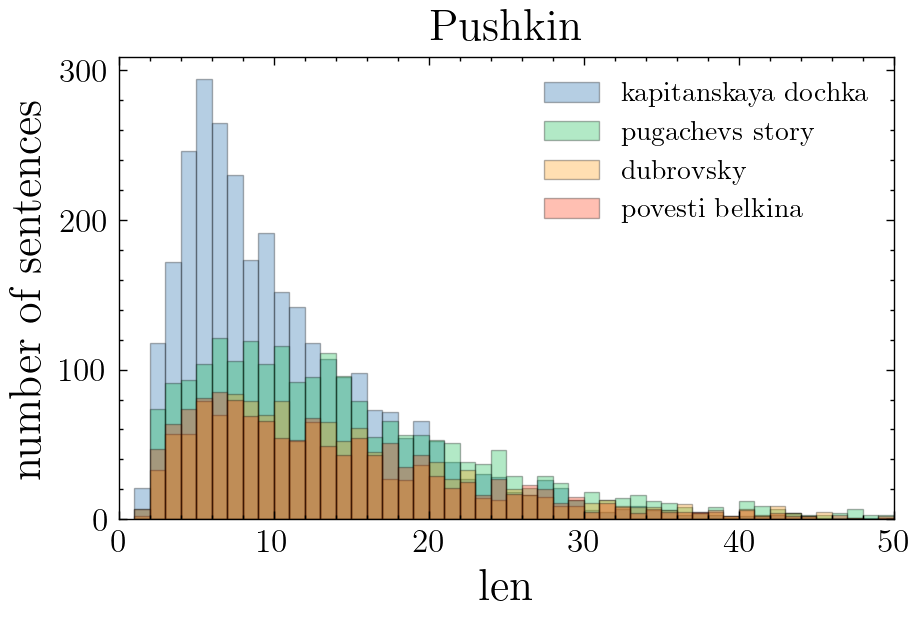

In [13]:
fig, ax = plt.subplots(figsize=(5, 3))

for ind, filename in enumerate(data_filenames):
    book_df = pd.read_csv(os.path.join(pushkin_data_dir, filename), index_col=0)
    book_df['len'] = book_df.apply(lambda row: len(row.target.split(' ')), axis = 1)

    n_bins = int((book_df['len'].max() - book_df['len'].min()) / 1)
    pd.DataFrame.hist(
        data=book_df,
        column='len',
        ax=ax,
        bins=n_bins,
        legend=False,
        # color='lightcoral',
        alpha=0.3,
        edgecolor='k',
        lw=0.5,
        label=filename.split('.')[0].replace('_', ' ')
    )

ax.set_title('Pushkin', fontsize=lables_fs)
ax.set_xlim([0, 50])

ax.tick_params(axis='both', which='major', labelsize=ticks_fs)

# plt.title(None)
plt.xlabel('len', fontsize=lables_fs)
plt.ylabel('number of sentences', fontsize=lables_fs)

ax.legend()
ax.grid(False)
plt.show()
# fig.savefig(f'figures/name.eps', format='eps')

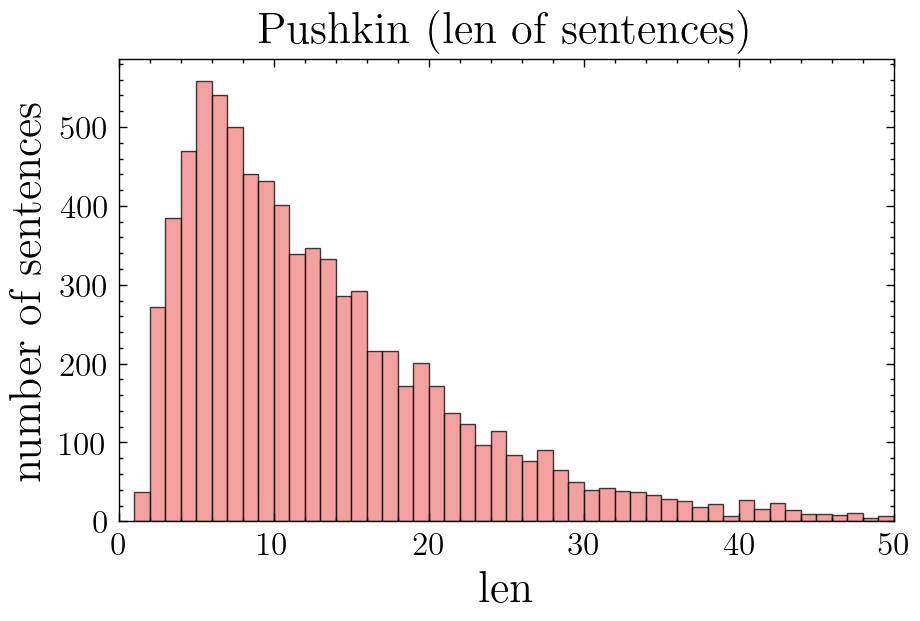

In [14]:
fig, ax = plt.subplots(figsize=(5, 3))

pushkin_sentences_df['len'] = pushkin_sentences_df.apply(lambda row: len(row.target.split(' ')), axis = 1)

n_bins = int((pushkin_sentences_df['len'].max() - pushkin_sentences_df['len'].min()) / 1)
pd.DataFrame.hist(
    data=pushkin_sentences_df,
    column='len',
    ax=ax,
    bins=n_bins,
    legend=False,
    color='lightcoral',
    alpha=0.75,
    edgecolor='k',
    lw=0.5,
)

ax.set_title('Pushkin (len of sentences)', fontsize=lables_fs)
ax.set_xlim([0, 50])

ax.tick_params(axis='both', which='major', labelsize=ticks_fs)

plt.xlabel('len', fontsize=lables_fs)
plt.ylabel('number of sentences', fontsize=lables_fs)

ax.grid(False)
plt.show()

# fig.savefig(f'figures/name.eps', format='eps')

In [15]:
print(f"Minimal len: {pushkin_sentences_df['len'].min()}")
print(f"Maximal len: {pushkin_sentences_df['len'].max()}")

Minimal len: 1
Maximal len: 183


In [16]:
lower_len_lim = 4
upper_len_lim = 20  # we will not use too long and too short sentences! 

len(
    pushkin_sentences_df[
        (pushkin_sentences_df['len'] >= lower_len_lim) &
        (pushkin_sentences_df['len'] <= upper_len_lim)
    ]
)

5912

#### Number of commas in sentences

In [17]:
pushkin_sentences_df['commas'] = pushkin_sentences_df.apply(
    lambda row: Counter(
        (row.target + ' C').split(' ')
    )['C'] - 1,
    axis = 1
)  # count number of commas in each target

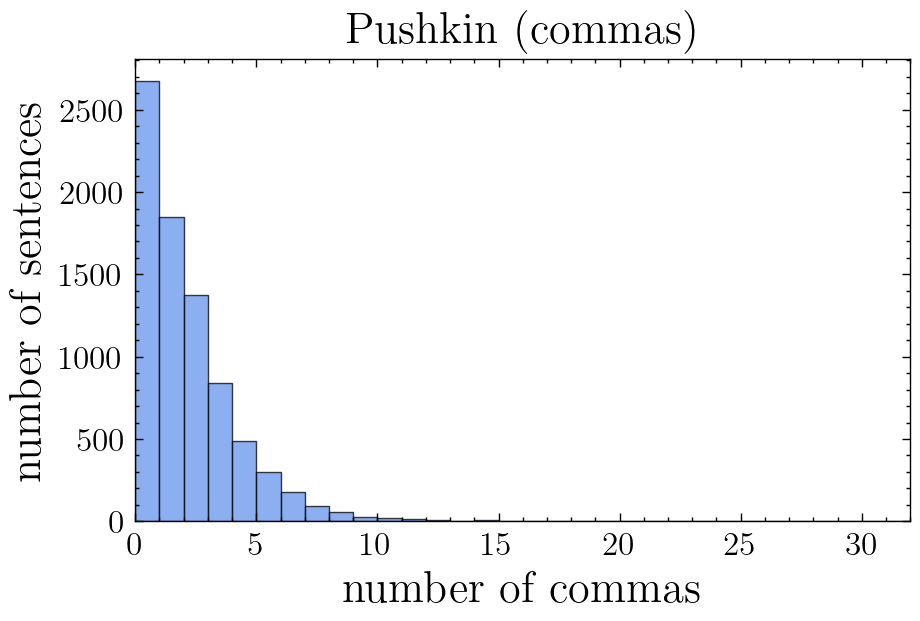

In [18]:
fig, ax = plt.subplots(figsize=(5, 3))

n_bins = int((pushkin_sentences_df['commas'].max() - pushkin_sentences_df['commas'].min()) / 1)
pd.DataFrame.hist(
    data=pushkin_sentences_df,
    column='commas',
    ax=ax,
    bins=n_bins,
    legend=False,
    color='cornflowerblue',
    alpha=0.75,
    edgecolor='k',
    lw=0.5,
)

ax.set_title('Pushkin (commas)', fontsize=lables_fs)
ax.set_xlim([0, pushkin_sentences_df['commas'].max()])

ax.tick_params(axis='both', which='major', labelsize=ticks_fs)

plt.xlabel('number of commas', fontsize=lables_fs)
plt.ylabel('number of sentences', fontsize=lables_fs)

ax.grid(False)
plt.show()

# fig.savefig(f'figures/name.eps', format='eps')

In [19]:
# number of sentences of desired length and with at least one comma in it
lower_len_lim = 3
upper_len_lim = 25

len(
    pushkin_sentences_df[
        (pushkin_sentences_df['len'] >= lower_len_lim) &
        (pushkin_sentences_df['len'] <= upper_len_lim) &
        (pushkin_sentences_df['commas'] > 0)
    ]
)

4455

### Punctuation statistics in selected Subset of the data

In [20]:
lower_len_lim = 3
upper_len_lim = 25

pushkin_data_df = pushkin_sentences_df[
    (pushkin_sentences_df['len'] >= lower_len_lim) &
    (pushkin_sentences_df['len'] <= upper_len_lim) &
    (pushkin_sentences_df['commas'] > 0)
]

print(pushkin_data_df.shape)
pushkin_data_df = pushkin_data_df.reset_index(drop=True)
pushkin_data_df.sample(5)

(4455, 4)


,input,target,len,commas
650,хорошо коли отсидимся или дождемся сикурса ну а коли злодеи возьмут крепость,C S S S S C C S S S S Q,12,3
3558,между тем тележка въехала на двор и знакомый уже нам исправник вошел в комнату весь запыленный,S S S S S C S S S S S S S S S P,16,1
3578,сию минуту отвечала дама марья кириловна встаньте посмотритесь хорошо ли,S C S C S C C C S Q,10,5
2519,они быстро заняли находившиеся близ предместья кирпичные сараи рощу и загородный дом кудрявцева устроили там свои батареи и сбили слабый отряд охранявший дорогу,S S S S S S S C S S S S C S S S S S S S C S P,23,3
4234,а там барыня пошла в село и призвала попа дала ему денег и поехала а мне дала пятак серебром славная барыня,S S S S S S S S C S S S S C S S S S C S EX,21,3


In [21]:
all_punctuation_in_data = []

for ind_row in range(pushkin_data_df.shape[0]):
    target_this = pushkin_data_df.iloc[ind_row]['target']

    # FIXING BUGS IN PROCESS!
    if (target_this[-1] == 'C') or (target_this[-1] == 'S') or (target_this[-1] == ' '):
        # check if last mark is '.'/'!' or '?'
        print(f'{ind_row}:\t[{target_this}] --> ', end=' ')
        fixed_target_this = target_this[:-1] + 'P'
        pushkin_data_df.loc[ind_row, 'target'] = fixed_target_this
        print(f'[{fixed_target_this}]')
    if ('Q' in target_this[:-1]) or ('EX' in target_this[:-1]):
        print(f'{ind_row}:\t[{target_this}] --> ', end=' ')
        fixed_target_this = target_this[:-1].replace('EX', 'C')
        fixed_target_this = fixed_target_this.replace('Q', 'C') + target_this[-1]
        pushkin_data_df.loc[ind_row, 'target'] = fixed_target_this
        pushkin_data_df.loc[ind_row, 'target'] = fixed_target_this
        print(f'[{fixed_target_this}]')

    all_punctuation_in_data.extend(pushkin_data_df.iloc[ind_row]['target'].split(' '))

410:	[S S S C S EX S S S S Q] -->  [S S S C S C S S S S Q]
1848:	[S S S S S C S S S S] -->  [S S S S S C S S S P]
1961:	[S S S S S S S S S S S C S S S S S C S S S S S S] -->  [S S S S S S S S S S S C S S S S S C S S S S S P]
2283:	[C S S S C S S S S C S S S C S S C S S S S S] -->  [C S S S C S S S S C S S S C S S C S S S S P]
2341:	[S S S S S S C S S S S S S] -->  [S S S S S S C S S S S S P]
2350:	[S S C S S S S S S S S] -->  [S S C S S S S S S S P]
2428:	[C S C S S S S S C S S C S S S] -->  [C S C S S S S S C S S C S S P]
3034:	[S C S S S S C S S S S S C S S C S S C S S S] -->  [S C S S S S C S S S S S C S S C S S C S S P]
4077:	[S S C EX S S S S S S S EX] -->  [S S C C S S S S S S S EX]


In [22]:
pushkin_data_df.iloc[410]

input     нашли за что ссориться за песенку да как же это случилось
target                                        S S S C S C S S S S Q
len                                                              11
commas                                                            1
Name: 410, dtype: object

In [23]:
assert len(all_punctuation_in_data) == pushkin_data_df['len'].sum()

In [24]:
punctuation_counter = Counter(all_punctuation_in_data)

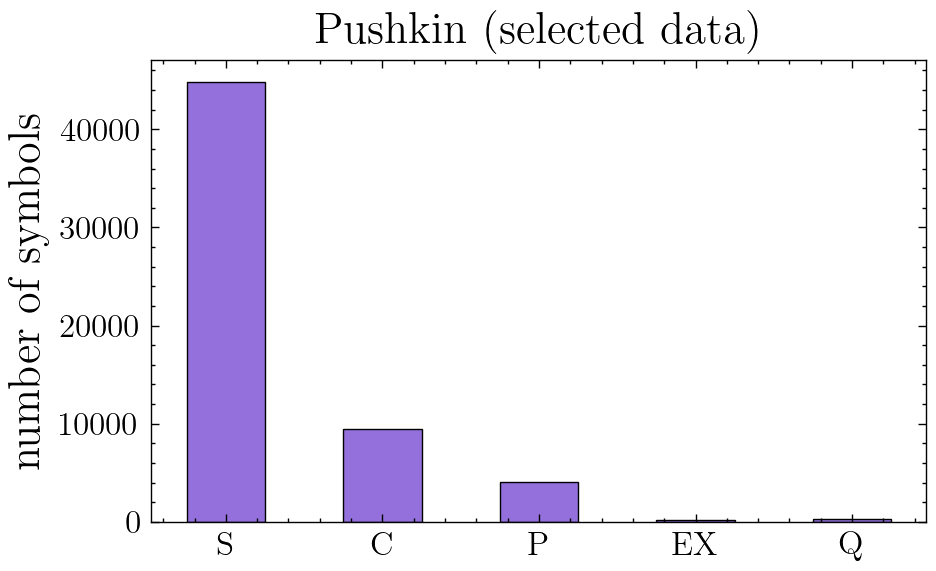

In [25]:
fig, ax = plt.subplots(figsize=(5, 3))

ax.bar(punctuation_counter.keys(), punctuation_counter.values(), 0.5, color='mediumpurple', edgecolor='k', lw=0.5)
ax.set_title('Pushkin (selected data)', fontsize=lables_fs)
# ax.set_xlim([0, 50])

ax.tick_params(axis='both', which='major', labelsize=ticks_fs)

# plt.xlabel('len', fontsize=lables_fs)
plt.ylabel('number of symbols', fontsize=lables_fs)

plt.show()

#### Classes are quite unbalanced!

`Spaces` occures $\sim5$ times more frequently than `commas` in main bodies of sentences!

In [26]:
print(f"RATIO(spaces / commas) = {punctuation_counter['S'] / punctuation_counter['C']:.3f}")

RATIO(spaces / commas) = 4.745


Among __end punctuation marks__ (in the end of sentences) the ratio is the following:

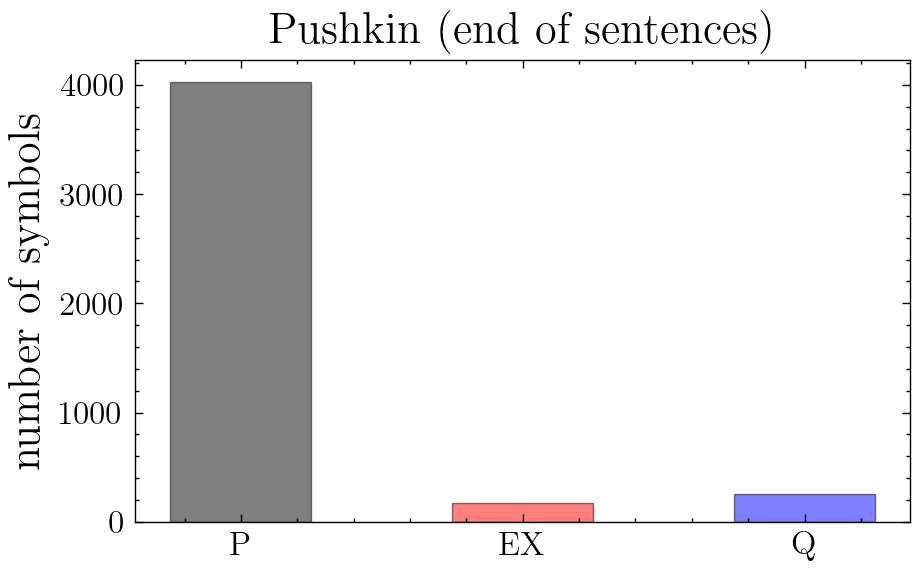

In [27]:
fig, ax = plt.subplots(figsize=(5, 3))

keys_to_plot = ['P', 'EX', 'Q']
ax.bar(
    keys_to_plot,
    [punctuation_counter[key] for key in keys_to_plot], 
    0.5, color=['k', 'r', 'b'], edgecolor='k', lw=0.5, alpha=0.5
)
ax.set_title('Pushkin (end of sentences)', fontsize=lables_fs)
# ax.set_xlim([0, 50])

ax.tick_params(axis='both', which='major', labelsize=ticks_fs)

# plt.xlabel('len', fontsize=lables_fs)
plt.ylabel('number of symbols', fontsize=lables_fs)

plt.show()

In [28]:
dict_names = {'P': 'point', 'EX': 'exclamation', 'Q': 'question'}
sum_control = 0
for key in ['P', 'EX', 'Q']:
    n_this = punctuation_counter[key]
    sum_control += n_this
    
    print(f"{dict_names[key] + (15 - len(dict_names[key])) * ' '}: {n_this}\t({n_this / pushkin_data_df.shape[0] * 100:.2f} %)")

assert sum_control == pushkin_data_df.shape[0]

point          : 4028	(90.42 %)
exclamation    : 176	(3.95 %)
question       : 251	(5.63 %)


### Saving selected and fixed data part

In [29]:
print(pushkin_data_df.shape)
pushkin_data_df.sample(10)

(4455, 4)


,input,target,len,commas
1705,накануне похода я пришел к моим родителям и по тогдашнему обыкновению поклонился им в ноги прося их благословения на брак с марьей ивановной,S S S S S S S S S S S S S S C S S S S S S S P,23,1
3957,продолжайте я расскажу после но продолжайте сделайте милость,C S S S S C S P,8,2
769,ротный портной вооруженный тупыми своими ножницами резал у них косы,S C S S S C S S S P,10,2
4339,нет ничего здоровее сказал он как просыпаться на заре,S S C S C S S S P,9,2
505,молю бога чтоб ты исправился хоть и не смею надеяться на его великую милость,S C S S C S S S S S S S S P,14,2
2953,няня стояла крыльце забыв о приказании барина,S S C S S S P,7,1
1469,но дворянину изменить своей присяге соединиться с разбойниками с убийцами с беглыми холопьями,S S S S C S S C S C S S EX,13,3
1842,6-я курхайский лов бывает обыкновенно весною и только в море или лучше сказать на взморье,C S S S S S S S S C C S C S P,15,4
4048,прочие все одеты были благопристойно покойницы в чепцах и лентах мертвецы чиновные в мундирах но с бородами небритыми купцы в праздничных кафтанах,S S S S C S S S S C S S S C S S S C S S S P,22,4
3054,зачем вы не спите спросил он их,S S S C S S P,7,1


In [30]:
prepared_dir = '../data/prepared'
filename_csv = '01_punct_pushkin.csv'

In [31]:
# saving dataframe (only 'input' and 'target' columns)
pushkin_data_df[['input', 'target']].to_csv(os.path.join(prepared_dir, filename_csv))